# 机器学习练习 3 - 多类分类
代码修改并注释：廖永,广东工业大学硕士在读,如有错误或指正,请联系136884000@qq.com
代码运行环境：python3.7

对于此练习，我们将使用逻辑回归来识别手写数字（0到9）。 我们将扩展我们在练习2中写的逻辑回归的实现，并将其应用于一对一的分类。 让我们开始加载数据集。 它是在MATLAB的本机格式，所以要加载它在Python，我们需要使用一个SciPy工具。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告


In [2]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

In [3]:
X, y = load_data('ex3data1.mat')

print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [4]:
def plot_an_image(image):
#     """
#     image : (400,)
#     """
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))
#绘图函数

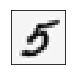

this should be 5


In [5]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print('this should be {}'.format(y[pick_one]))  #对应数据集中的y

# 数据可视化

In [6]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1])) #获取向量X的列数，并计算其平方根，取整型。

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # X.shape[0]是获取X的行数长度400，即从400中随机选100个数
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))#创建图

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),#reshpe()改变数组形状
                                   cmap=matplotlib.cm.binary)  #camp表示一种颜色映射方式
            plt.xticks(np.array([]))#设置X轴的刻度
            plt.yticks(np.array([]))  #设置y轴的刻度
            #绘图函数，画100张图片

In [7]:
def load_data(path, transpose=True):  # transposen:矩阵转置函数
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector 

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

In [8]:
X, y = load_data('ex3data1.mat')

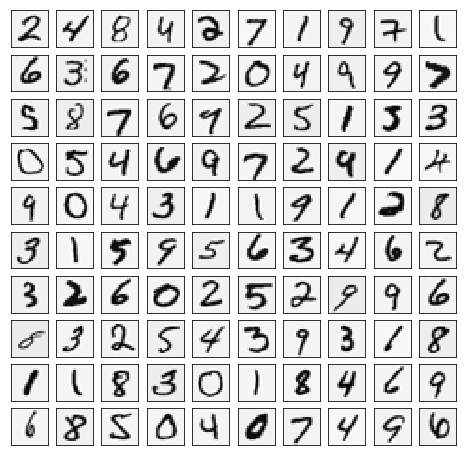

In [9]:
plot_100_image(X)
plt.show()

In [10]:
raw_X, raw_y = load_data('ex3data1.mat')
print(raw_X.shape)
print(raw_y.shape)

(5000, 400)
(5000,)


# 准备数据

In [11]:
# add intercept=1 for x0
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)#插入了第一列（全部为1）
X.shape

(5000, 401)

In [12]:
# y have 10 categories here. 1..10, they represent digit 0 as category 10 because matlab index start at 1
# I'll ditit 0, index 0 again
y_matrix = []

for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int)) #append是在数组后加上相应的元素，astype是数值类型转换函数

# last one is k==10, it's digit 0, bring it to the first position，最后一列k=10，都是0，把最后一列放到第一列
y_matrix = [y_matrix[-1]] + y_matrix[:-1] #y_matrix中最后一个元素加上原来整个数组
y = np.array(y_matrix) 

y.shape#查看矩阵的维数

# 扩展 5000*1 到 5000*10
#     比如 y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """

(10, 5000)

In [13]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

# train 1 model（训练一维模型）

### 代价函数
$$
J(\theta)=\frac{1}{m} \sum_{i=1}^{m}\left[-y^{(i)} \log \left(h_{\theta}\left(x^{(i)}\right)\right)-\left(1-y^{(i)}\right) \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)\right]
$$

In [14]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta))) #np.mean():求平均值

### 正则化后的代价函数
$$
J(\theta)=\frac{1}{m} \sum_{i=1}^{m}\left[-y^{(i)} \log \left(h_{\theta}\left(x^{(i)}\right)\right)-\left(1-y^{(i)}\right) \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)\right]+\frac{\lambda}{2 m} \sum_{j=1}^{n} \theta_{j}^{2}
$$

In [15]:
def regularized_cost(theta, X, y, l=1): #l是正则化参数lamda
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum() #power:求次方函数 sum:求和函数

    return cost(theta, X, y) + regularized_term

### 偏导数更新
$$
\begin{aligned} \frac{\partial J(\theta)}{\partial \theta_{0}} &=\frac{1}{m} \sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)} \quad \text { for } j=0 \\ \frac{\partial J(\theta)}{\partial \theta_{j}} &=\left(\frac{1}{m} \sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)}\right)+\frac{\lambda}{m} \theta_{j} \quad \text { for } j \geq 1 \end{aligned}
$$

In [16]:
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])#np.concatenate（）：数组拼接函数

    return gradient(theta, X, y) + regularized_term

# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### 梯度下降函数
$$
\frac{\partial J}{\partial \theta_{j}}=\frac{1}{m} \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)}\right)
$$

In [18]:
def gradient(theta, X, y):
    '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [19]:
def logistic_regression(X, y, l=1):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.zeros(X.shape[1]) #创建与X的列数相同长度的0数组

    # train it
     #梯度下降法最小化代价函数
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True}) 
    # get trained parameters
    final_theta = res.x

    return final_theta

In [20]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)


In [21]:
t0 = logistic_regression(X, y[0])

In [22]:
print(t0.shape)
y_pred = predict(X, t0)
print('Accuracy={}'.format(np.mean(y[0] == y_pred)))

(401,)
Accuracy=0.9974


# train k model（训练k维模型）

In [23]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])
print(k_theta.shape)# shape：查看矩阵或数组的维数

(10, 401)


# 进行预测
* think about the shape of k_theta, now you are making $X\times\theta^T$
> $(5000, 401) \times (10, 401).T = (5000, 10)$
* after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer

In [24]:
prob_matrix = sigmoid(X @ k_theta.T)

In [25]:
np.set_printoptions(suppress=True) #打印全部函数
prob_matrix

array([[0.99577353, 0.        , 0.00053536, ..., 0.0000647 , 0.00003916,
        0.00172426],
       [0.99834639, 0.0000001 , 0.00005611, ..., 0.00009681, 0.00000291,
        0.00008494],
       [0.99139822, 0.        , 0.00056824, ..., 0.00000655, 0.02655352,
        0.00197512],
       ...,
       [0.00000068, 0.04144103, 0.00321037, ..., 0.00012724, 0.00297365,
        0.707625  ],
       [0.00001843, 0.00000013, 0.00000009, ..., 0.00164807, 0.0680994 ,
        0.86118731],
       [0.02879745, 0.        , 0.00012979, ..., 0.36617606, 0.00498225,
        0.14829291]])

In [26]:
y_pred = np.argmax(prob_matrix, axis=1)#返回沿轴axis最大值的索引，axis=1代表行  #返回每个数组中行方向最大值的下标(下标由0开始记起)

In [27]:
y_pred

array([0, 0, 0, ..., 9, 9, 7], dtype=int64)

In [28]:
y_answer=raw_y.copy()
#copy仅拷贝对象本身，而不对中的子对象进行拷贝，故对子对象进行修改也会随着修改。
#eepcopy是真正意义上的复制，即从新开辟一片空间。我们经常说的复制实际上就是deepcopy.

y_answer[y_answer==10]=0

In [29]:
print(classification_report(y_answer, y_pred))  #y_answer为真实值，y_pred为预测值，classification_report（）是sklearn库的一个评价函数

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       500
          1       0.95      0.99      0.97       500
          2       0.95      0.92      0.93       500
          3       0.95      0.91      0.93       500
          4       0.95      0.95      0.95       500
          5       0.92      0.92      0.92       500
          6       0.97      0.98      0.97       500
          7       0.95      0.95      0.95       500
          8       0.93      0.92      0.92       500
          9       0.92      0.92      0.92       500

avg / total       0.94      0.94      0.94      5000



其中列表左边的一列为分类的标签名，右边support列为每个标签的出现次数

# 神经网络模型图示


In [30]:
def load_weight(path):
    data = sio.loadmat(path) #loadmat():加载mat文件
    return data['Theta1'], data['Theta2']

In [31]:
theta1, theta2 = load_weight('ex3weights.mat')

theta1.shape, theta2.shape

((25, 401), (10, 26))

因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）

In [32]:
X, y = load_data('ex3data1.mat',transpose=False)   #load_data为矩阵转置函数

X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)  # intercept
#X.shape[0]:获取X的行数. 0:在X的第0列插入 value:插入内容  axis=1是指插入列

X.shape, y.shape

((5000, 401), (5000,))

# feed forward prediction（前馈预测）
![](https://i.loli.net/2019/08/25/evE9DU4gdrRlBYA.png)


In [33]:
a1=X

In [34]:
z2=np.dot(a1,theta1.T) # .dot(A,B)函数是点乘的作用，与@(A,B)的作用相同
z2.shape

(5000, 25)

In [35]:
z2=np.insert(z2,0,values=np.ones(X.shape[0]), axis=1)

In [36]:
z2.shape

(5000, 26)

In [37]:
a2=sigmoid(z2)

In [38]:
z3=np.dot(a2,theta2.T)
z3.shape

(5000, 10)

In [39]:
a3=sigmoid(z3)
a3

array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326,
        0.99622946],
       [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617,
        0.99619667],
       [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 ,
        0.93586278],
       ...,
       [0.06278247, 0.00450406, 0.03545109, ..., 0.0026367 , 0.68944816,
        0.00002744],
       [0.00101909, 0.00073436, 0.00037856, ..., 0.01456166, 0.97598976,
        0.00023337],
       [0.00005908, 0.00054172, 0.0000259 , ..., 0.00700508, 0.73281465,
        0.09166961]])

In [40]:
y_pred = np.argmax(a3, axis=1) + 1  # numpy is 0 base index, +1 for matlab convention，返回沿轴axis最大值的索引，axis=1代表行
y_pred.shape

(5000,)

# 准确率
 
虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。

In [41]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          1       0.97      0.98      0.97       500
          2       0.98      0.97      0.97       500
          3       0.98      0.96      0.97       500
          4       0.97      0.97      0.97       500
          5       0.98      0.98      0.98       500
          6       0.97      0.99      0.98       500
          7       0.98      0.97      0.97       500
          8       0.98      0.98      0.98       500
          9       0.97      0.96      0.96       500
         10       0.98      0.99      0.99       500

avg / total       0.98      0.98      0.98      5000

